# Data download

In [18]:
import boto3


s3 = boto3.resource(
    's3',
    aws_access_key_id="",
    aws_secret_access_key="",
)
bucket = s3.Bucket('amazon-braket-us-east-1-826670407271')
for i, obj in enumerate(bucket.objects.filter(Prefix='task3/')):
    s3.Object(bucket_name=bucket.name, key=obj.key).download_file(Filename=f'/home/jkambulo/projects/def-rgmelko/jkambulo/data/quera_data/task3/results{i}.json')

task3/01c6f14a-9352-4ea8-b1e8-03dc69de8d41/results.json
task3/0783a10b-ad8e-4467-bb47-1dcd7874049b/results.json
task3/0d0ee91a-a0c2-4376-a241-ce13d83f30c2/results.json
task3/119433cd-86be-4476-9738-2f89cc1e764e/results.json
task3/11cf3067-227e-4901-a5e0-5ba17586ff9a/results.json
task3/1389d5f1-e2d3-4a29-8bf9-8c7d1d44d5d3/results.json
task3/15998e82-0a61-4be4-856f-4c32fc0ea022/results.json
task3/19e39f05-9a96-40da-abec-d7319f86a9eb/results.json
task3/1ca5750f-9a58-4469-be13-5848930875ba/results.json
task3/2407c86d-6793-4b30-9d9b-7723f9b47213/results.json
task3/27391469-4ab1-486e-b3b6-f76def758982/results.json
task3/2d8d3f2e-159e-4678-9e80-2390b6780e7a/results.json
task3/2f3ac8a2-1306-4d24-a004-302d00392b7d/results.json
task3/319a9324-1cdc-42fe-af56-9d7570567136/results.json
task3/35071b87-3378-4957-88d0-d4b832558509/results.json
task3/3649ac07-f052-41ad-9178-3df838e70806/results.json
task3/389481d8-ff3f-49a6-aad4-97dca9fe9712/results.json
task3/38e1b6ae-7762-407a-a507-b4d981a6d339/resul

# Data processing

In [119]:
import os
import json
import datetime
import numpy as np

concatenated_dictionary = {"measurements":[]}
path = "/home/jkambulo/projects/def-rgmelko/jkambulo/data/quera_data/task4"
end_times = []
for filename in os.listdir(path):
    if not filename.endswith('.json'):
        continue
    
    with open(os.path.join(path, filename)) as file:
        data = json.load(file)
        assert data['measurements'][0]['shotMetadata']['shotStatus'] == "Success"
        end_times.append(datetime.datetime.fromisoformat(data['taskMetadata']['endedAt'][:-1]))
        concatenated_dictionary['measurements'].extend(data["measurements"])
        
    C = 2*np.pi * 862690
    omega = data['additionalMetadata']['action']['hamiltonian']['drivingFields'][0]['amplitude']['time_series']['values'][-2]
    delta = data['additionalMetadata']['action']['hamiltonian']['drivingFields'][0]['detuning']['time_series']['values'][-2]
    a =  data['additionalMetadata']['action']['setup']['ahs_register']['sites'][1][1]
    Rb = abs(C/(omega*1e-6))**(1/6)
        
    if "braketSchemaHeader" not in concatenated_dictionary.keys():
        print(f"delta/omega={delta/omega}, Rb/a={Rb*1e-6/a}")
        concatenated_dictionary['braketSchemaHeader'] = data["braketSchemaHeader"]
        concatenated_dictionary['taskMetadata'] = data["taskMetadata"]
        concatenated_dictionary['additionalMetadata'] = data["additionalMetadata"]

delta/omega=0.8, Rb/a=1.1461463193850239


0.37734095 0.010055302727789947


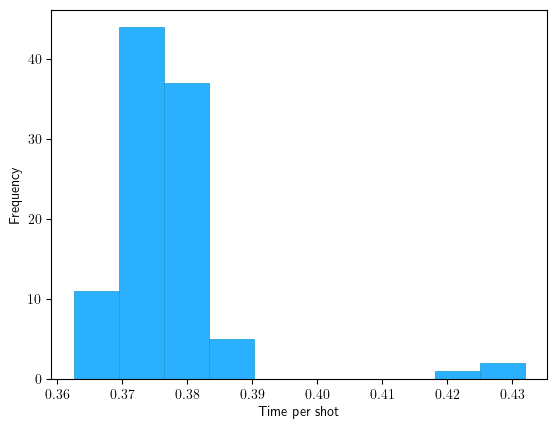

In [89]:
# !rm -rf  ~\.cache\matplotlib
# import matplotlib.font_manager
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
# mpl.rcParams['font.family'] = ['serif']
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['text.usetex'] = True
# plt.rcParams["svg.fonttype"] = 'none'


data = [x.total_seconds()/1000 for x in np.diff(sorted(end_times)) if x.total_seconds() < 500]
fig = plt.figure()
plt.hist(data,  facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel("Time per shot")
plt.ylabel("Frequency")
# fig.savefig('image.pdf', transparent=True)
# plt.close(fig)

print(np.mean(data), np.std(data))

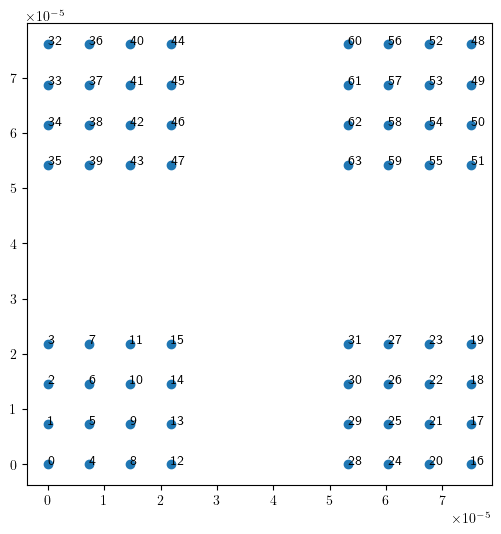

In [90]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
x, y = np.array(concatenated_dictionary['additionalMetadata']['action']['setup']['ahs_register']['sites']).T
plt.scatter(x, y)
for i,(X,Y) in enumerate(zip(x,y)):
    plt.text(X,Y,i)

In [110]:
import h5py

concatenated_dictionary['measurements'][0]['shotResult']['postSequence']
measurements = len(concatenated_dictionary['measurements'])
atoms = len(concatenated_dictionary['measurements'][0])
with h5py.File(os.path.join(path, 'aquila.h5'), 'w') as file:
    file['postSequence'] = np.array([spins['shotResult']['postSequence'] for spins in concatenated_dictionary['measurements']])
    file['preSequence'] = np.array([spins['shotResult']['preSequence'] for spins in concatenated_dictionary['measurements']])
    file['sites'] = concatenated_dictionary['additionalMetadata']['action']['setup']['ahs_register']['sites']
    file['hamiltonian/time_series'] = concatenated_dictionary['additionalMetadata']['action']['hamiltonian']['drivingFields'][0]['amplitude']['time_series']['times']
    file['hamiltonian/amplitude'] = concatenated_dictionary['additionalMetadata']['action']['hamiltonian']['drivingFields'][0]['amplitude']['time_series']['values']
    file['hamiltonian/phase'] = concatenated_dictionary['additionalMetadata']['action']['hamiltonian']['drivingFields'][0]['phase']['time_series']['values']
    file['hamiltonian/detuning'] = concatenated_dictionary['additionalMetadata']['action']['hamiltonian']['drivingFields'][0]['detuning']['time_series']['values']
    # file['hamiltonian/pattern'] = concatenated_dictionary['additionalMetadata']['action']['hamiltonian']['drivingFields'][0]['amplitude']['pattern']
    

In [92]:
# diagnosing presequence error
with h5py.File(os.path.join(path, 'aquila.h5'), 'r') as file:
    problematic = np.sum(np.sum(1-file['preSequence'][:], axis=1)>0)
    print("Fraction of measurements with incorrect start:", problematic/len(file['preSequence']))
    
    print("Rate of gaining an atom with wrong presequence:", np.sum((1-file['preSequence'][:])*file['postSequence'][:])/np.sum(1-file['preSequence'][:]))
    

Fraction of measurements with incorrect start: 0.30150485436893204
Rate of gaining an atom with wrong presequence: 0.0015336597965882796


0.8


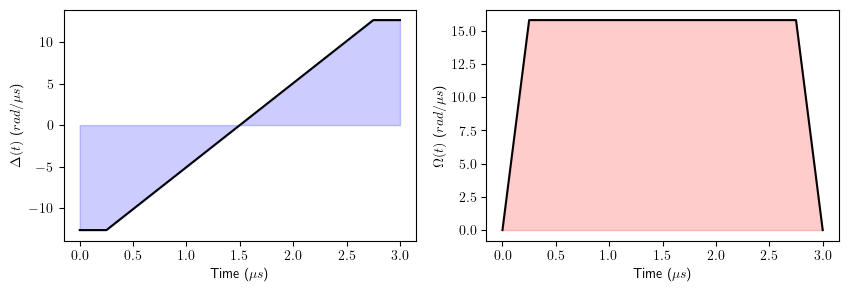

In [93]:
with h5py.File(os.path.join(path, 'aquila.h5'), 'r') as file:
    t = file['hamiltonian/time_series'][:]
    ampl = file['hamiltonian/amplitude'][:]
    detuning = file['hamiltonian/detuning'][:]
    a = file['sites'][1,1]
    # print(a)
    # print(detuning)
    # print(ampl)
    print(np.max(detuning)/np.max(ampl))

fig,ax = plt.subplots(1,2, figsize=(10,3))

ax[0].plot(t*1e6, detuning/1e6, c='k')
ax[0].set_xlabel("Time ($\mu s$)")
ax[0].set_ylabel(r"$\Delta(t)$ ($rad/\mu s$)")
ax[0].fill_between(t*1e6,detuning/1e6, color= "b", alpha= 0.2)

ax[1].plot(t*1e6, ampl/1e6,c='k')
ax[1].set_xlabel("Time ($\mu s$)")
ax[1].set_ylabel(r"$\Omega(t)$ ($rad/\mu s$)")
ax[1].fill_between(t*1e6,ampl/1e6, color= "r", alpha= 0.2)
# fig.subplots_adjust(left=0.3, right=0.95, bottom=0.5, top=1)
fig.savefig("adiabatic_hamiltonian.pdf", transparent=True, bbox_inches = "tight")


## Reorganizing data to keep all datasets seperate

In [111]:
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt

# path = "/home/jkambulo/projects/def-rgmelko/jkambulo/data/quera_data"

def rotate_transform(x, i:int, axis:int=0):
    """Converts the 4x4 arrays in the dataset to be a consistent orientation

    Args:
        x (np.array): Array of size (X, 16) or (16, X) 
        i (int): Which of the four grids the 4x4 array corresponds to. Defines which transformation will be applied 
        axis (int, optional): Which axis has a size of 16 and will be rotated. Defaults to 0. Either 0 or 1

    Returns:
        tensor: Rotated version of x
    """
    if axis == 1:
        x = x.T
        
    indices = np.arange(16).reshape(4,4)
    if i == 0:
        output = x[np.rot90(indices, k=1).flatten()]
    elif i == 1:
        output = x[np.rot90(indices.T, k=2).flatten()]
    elif i == 2:
        output = x[indices.T.flatten()]
    else:
        output = x[np.rot90(indices, k=-1).flatten()]

    if axis == 1:
        return output.T
    return output
        
        
with h5py.File(os.path.join(path, 'split_aquila.h5'), 'w') as new_file:
    with h5py.File(os.path.join(path, 'aquila.h5'), 'r') as old_file:
        shots, atoms = old_file['postSequence'].shape
        new_file.create_dataset('postSequence/all',(shots*4, atoms//4), dtype='i')
        new_file.create_dataset('preSequence/all',(shots*4, atoms//4), dtype='i')
        
        filter_transform = lambda data, i, axis=1: data[:,i*16:(i+1)*16] if axis==1 else data[i*16:(i+1)*16]
        for i in range(4):
            post_sequence = rotate_transform(filter_transform(old_file['postSequence'], i),i, axis=1)
            # print(filter_transform(old_file['postSequence'],i).shape)
            pre_sequence = rotate_transform(filter_transform(old_file['preSequence'], i),i, axis=1)
            new_file[f'postSequence/{i}'] = post_sequence
            new_file[f'preSequence/{i}'] = pre_sequence
            new_file['postSequence/all'][i*shots:(i+1)*shots] = post_sequence
            new_file['preSequence/all'][i*shots:(i+1)*shots] = pre_sequence
            print(old_file['sites'].shape)
            new_file[f'sites/{i}'] = rotate_transform(filter_transform(old_file['sites'],i, axis=0),i, axis=0)

(64, 2)
(64, 2)
(64, 2)
(64, 2)


(16, 2)
(16, 2)
(16, 2)
(16, 2)


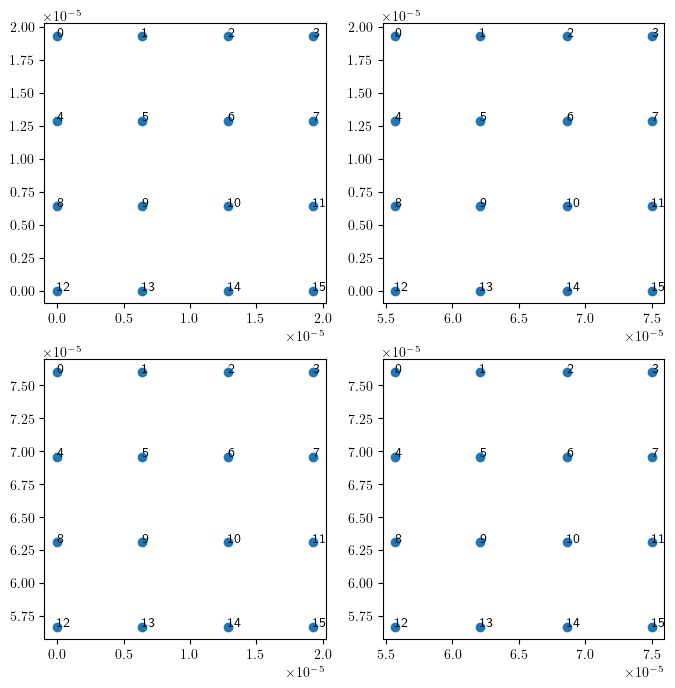

In [112]:
with h5py.File(os.path.join(path, 'split_aquila.h5'), 'r') as file:
    fig,ax = plt.subplots(2,2, figsize=(8,8))
    for k in range(4):
        print(file[f'sites/{k}'][:].shape)
        ax[k//2, k%2].scatter(*(file[f'sites/{k}'][:].T))
        for i,(x, y) in enumerate(file[f'sites/{k}']):
            ax[k//2, k%2].text(x,y,i)
    plt.show()

Fraction of measurements with incorrect start: 0.08622572815533981
Rate of gaining an atom with wrong presequence: 0.0015336597965882796
(412000, 16)


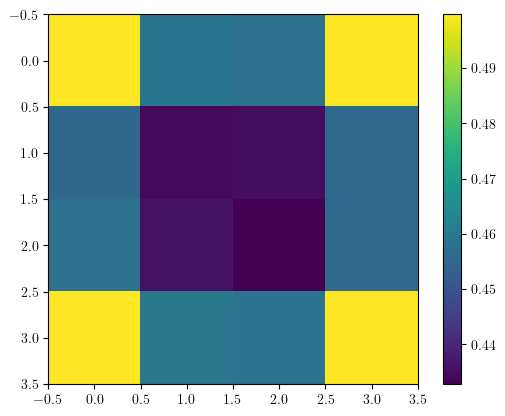

In [96]:
# diagnosing presequence error
with h5py.File(os.path.join(path, 'split_aquila.h5'), 'r') as file:
    problematic = np.sum(np.sum(1-file['preSequence/all'][:], axis=1)>0)
    print("Fraction of measurements with incorrect start:", problematic/len(file['preSequence/all']))
    
    print("Rate of gaining an atom with wrong presequence:", np.sum((1-file['preSequence/all'][:])*file['postSequence/all'][:])/np.sum(1-file['preSequence/all'][:]))
    

with h5py.File(os.path.join(path, 'split_aquila.h5'), 'r') as file:
    print(file['postSequence/all'].shape)
    plt.imshow(np.std(file['postSequence/all'][:].reshape(-1,4,4), axis=0))
    plt.colorbar()


# Processing Data for RydberGPT

In [45]:
import os
import pandas as pd
import json
import h5py

# Looking at what the format should be
folder = "/home/jkambulo/projects/def-rgmelko/jkambulo/data/rydbergGPT/BloqadeQMC_L=11_Rb=1.15_delta=2.94_beta=0.5"
config_path = os.path.join(folder,"config.json")
data_path = os.path.join(folder, "dataset.h5")
graph_path = os.path.join(folder, "graph.json")

df = pd.read_hdf(data_path)
with open(graph_path, 'r') as f:
    graph = json.load(f)
with open(config_path, 'r') as f:
    config = json.load(f)
    
    
######## Converting my data to this format ############

# quera_path = "/home/jkambulo/projects/def-rgmelko/jkambulo/data/quera_data"
with h5py.File(os.path.join(path, 'split_acquila.h5'), 'r') as file:
    new_config = {"omega":1,"lx":4,"ly":4,"beta":2.8,"num_atoms":4*4,"delta":1.2,"Rb":1.15}
    new_df = pd.DataFrame(columns=["measurements"], dtype=object)
    new_df['measurements'] = list(file['postSequence/all'][:])
    new_graph = {'directed': False,  "multigraph":False, "graph":{},
                 "nodes":[{"pos":[i//4, i%4], 'id':i} for i in range(16)],
                 "links":[{"weight":1/((i%4-j%4)**2+(i//4 - j//4)**2)**3, "source":i, "target":j} for i in range(16) for j in range(i+1,16)]}

with open("/home/jkambulo/projects/def-rgmelko/jkambulo/data/quera_data_rydbergpt/graph.json", 'w') as f:
    f.write(json.dumps(new_graph))

with open("/home/jkambulo/projects/def-rgmelko/jkambulo/data/quera_data_rydbergpt/config.json", 'w') as f:
    f.write(json.dumps(new_config))
        
new_df.to_hdf("/home/jkambulo/projects/def-rgmelko/jkambulo/data/quera_data_rydbergpt/dataset.h5", 'df')


{'omega': 1.0, 'lx': 11, 'ly': 11, 'beta': 0.5, 'num_atoms': 121, 'delta': 2.9375, 'Rb': 1.15}
                                             measurement
0      [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
1      [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...
2      [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...
3      [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...
4      [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...
...                                                  ...
99995  [1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...
99996  [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
99997  [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
99998  [0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...
99999  [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...

[100000 rows x 1 columns]


/tmp/ipykernel_24832/4067900199.py:36: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['measurements'], dtype='object')]

  new_df.to_hdf("/home/jkambulo/projects/def-rgmelko/jkambulo/data/quera_data_rydbergpt/dataset.h5", 'df')


# Analysis

In [100]:
%cd /project/6000317/jkambulo/code/qc-temp/transformer
import numpy as np
import matplotlib.pyplot as plt
from dataloader import QCTempDataset
from scipy.spatial.distance import jensenshannon
# plt.style.use('../../style.mplstyle')

# !python -m pip install scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon

def compute_histograms(data):
    natoms = data.shape[1]
    f = lambda x: np.sum(x*(2**np.arange(natoms))[None], axis=1)
    ncomb = 2**natoms

    bins = np.arange(ncomb)
    hist = np.histogram(f(data), bins=bins)[0]       
    index_commonality = np.argsort(hist)
    return hist, index_commonality


def plot_common_configurations(p, index_commonality, natoms, delta=1.2, rb=1.15,show=True, save_filename=None, title=""):
    bins = np.arange(2**natoms)
    freq = p[index_commonality[-1]]
    print(f"{freq*100} +- {np.sqrt(freq/1e6)*100}")

    nx, ny = 7,3
    _, axs = plt.subplots(ny, nx, figsize=(9, 5))
    nx_atoms = int(round(np.sqrt(natoms)))
    for j in range(nx*ny):
        i = index_commonality[-(j+1)]
        ax = axs.flatten()[j]
        ax.axis('off')
        ax.imshow(np.array(list(np.binary_repr(bins[i],width=natoms)),dtype=int).reshape((nx_atoms,nx_atoms)),cmap='magma')
        ax.set_title(rf"{p[i]*100:.4f}\%")
    plt.subplots_adjust(left=0,
                        bottom=0,
                        right=1,
                        top=0.85,
                        wspace=0,
                        hspace=0.4)
    plt.suptitle(rf"$\Delta/\Omega={delta:.2f}$, $R_b/a={rb:.2f}$ {title}")
    
    if save_filename:
        plt.savefig(save_filename, transparent=True)
    elif show:
        plt.show()
        
    

def compute_histograms2(dataset: QCTempDataset, dataset_slice=slice(None), filter_data=slice(None), atoms=None):
    natoms = atoms if atoms else dataset.get_natoms()
    f = lambda x: np.sum(x*(2**np.arange(natoms))[None], axis=1)
    data_list = dataset.datasets[dataset_slice]
    beta_list = dataset.beta[dataset_slice]
    order_param_list = dataset.order_param[dataset_slice]
    ncomb = 2**natoms

    bins = np.arange(ncomb)
    hist_list = [np.histogram(f(data[:][filter_data].T), bins=bins)[0] for data in data_list]        
    index_commonality = [np.argsort(hist) for hist in hist_list]
    order_params, op_counts = zip(*[np.unique(order_param, return_counts=True) for order_param in order_param_list])
    magnetization = [np.sum(data[filter_data],axis=0) for data in data_list]
    average_magnetization = [np.mean(mag) for mag in magnetization]
    std_av_magnetization = [np.std(mag)/np.sqrt(len(mag)-1) for mag in magnetization]
    return (bins, hist_list), (order_params[0], op_counts), (average_magnetization, std_av_magnetization), index_commonality, beta_list 


def plot_JSD2(p_list1, p_list2, beta_list1, beta_list2, delta=1.2, rb=1.15, show=True, save_filename=None):                
    for i, p1 in enumerate(p_list1):
        y = []
        for j, p2 in enumerate(p_list2): 
            y.append(jensenshannon(p1, p2))
        #     print(f"KLdiv beteen β={beta_list[i]:.3} and β={beta_list[j]:.3}: {np.sum(hist1[_filter]*np.log(hist1[_filter]/hist2[_filter]))/nsamples}")
        # print()
        
        plt.plot(beta_list2, y, label=rf"QMC $\beta_2\Omega={beta_list1[i]:.3f}$")
    plt.legend()
    plt.grid()
    plt.title(rf'$\Delta/\Omega={delta}$, $R_b/a={rb}$, 4x4 array')
    plt.xlabel(r'$\beta_1\Omega$')
    plt.ylabel(r'$JSD(p(\beta_1)||p(\beta_2))$')
    if save_filename:
        plt.savefig(save_filename, transparent=True)
    if show:
        plt.show()


def plot_JSD(target_p, p_list, x_values, title="", xlabel="", label="", show=True, save_filename=None):   
    index = np.argsort(x_values)    
    y = []
    for j, p2 in enumerate(np.array(p_list)[index]): 
        y.append(jensenshannon(target_p, p2))
    #     print(f"KLdiv beteen β={beta_list[i]:.3} and β={beta_list[j]:.3}: {np.sum(hist1[_filter]*np.log(hist1[_filter]/hist2[_filter]))/nsamples}")
    # print()
    
    plt.plot(np.array(x_values)[index], y, label=label)
    plt.legend()
    plt.grid()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(r'$JSD(p_1||p_2)$')
    if save_filename:
        plt.savefig(save_filename, transparent=True)
    elif show:
        plt.show()
    # Ω_list = [1]
    # Δ_per_Ω_list = [1.60,1.63,1.66]
    # Rb_per_a_list = [1.16,1.18,1.20]
    # nx_list = [4]
    # βΩ_list = [2.81, 2.91, 3]

from dataloader import QCTempDataset
# dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp", 
# size=(4,4), Rb_per_a=1.15, delta_per_omega=1.2)
dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp", 
                        size=(4,4),
                        query_rb_per_a=lambda x: x==1.15,
                        query_beta=lambda x: (x >= 0.1) & (x <= 5), 
                        query_delta_per_omega=lambda x: x==1.20
                        )



/project/6000317/jkambulo/code/qc-temp/transformer


In [101]:
dataset.datasets

[<HDF5 dataset "occs": shape (16, 10000000), type "<f8">,
 <HDF5 dataset "occs": shape (16, 10000000), type "<f8">,
 <HDF5 dataset "occs": shape (16, 10000000), type "<f8">,
 <HDF5 dataset "occs": shape (16, 10000000), type "<f8">,
 <HDF5 dataset "occs": shape (16, 10000000), type "<f8">,
 <HDF5 dataset "occs": shape (16, 10000000), type "<f8">,
 <HDF5 dataset "occs": shape (16, 10000000), type "<f8">,
 <HDF5 dataset "occs": shape (16, 10000000), type "<f8">,
 <HDF5 dataset "occs": shape (16, 10000000), type "<f8">,
 <HDF5 dataset "occs": shape (16, 10000000), type "<f8">,
 <HDF5 dataset "occs": shape (16, 10000000), type "<f8">]

In [1]:
import pandas as pd

df = pd.read_csv("/home/jkambulo/projects/def-rgmelko/jkambulo/code/qc-temp/full_JSD.csv")
# df = df.sort_values(by="beta*omega")

for i, data in enumerate(dataset.datasets):
    data = np.mean(data, axis=0)
    df.loc[i, 'QMC_mean'] = np.mean(data)
    df.loc[i, 'QMC_mean_std'] = np.std(data)
    del data
    
# df.to_csv('full2_JSD.csv')


NameError: name 'dataset' is not defined

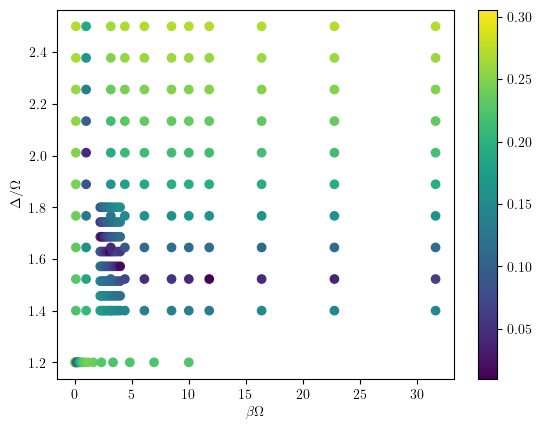

In [15]:
# occupation = np.array([np.mean(data[:,:100]) for data in dataset.datasets])
import matplotlib
matplotlib.rcParams['text.usetex'] = True
occ = []
for data in dataset.datasets:
    # print(data)
    occ.append(np.mean(data[:,:100000]))
occupation = np.array(occ)
plt.scatter(np.array(dataset.beta)*np.array(dataset.omega),dataset.delta_per_omega, 
            c=np.sqrt(np.abs(occupation-0.3997578125)))
plt.xlabel(r"$\beta\Omega$")
plt.ylabel(r'$\Delta/\Omega$')
# plt.xlim([2,4])
plt.colorbar()
# plt.savefig("occupation.png")
# plt.xscale('log')


Text(0.5, 1.0, 'Best guesses for the correct point in the phase space')

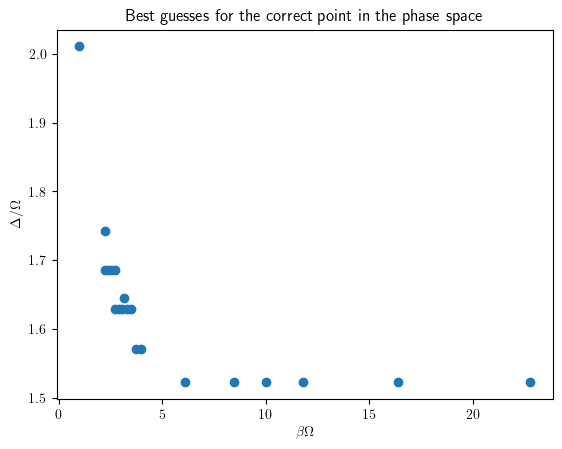

In [20]:
i = np.argsort(np.abs(occupation-0.3997578125))[:20]
plt.scatter((np.array(dataset.beta)*np.array(dataset.omega))[i],np.array(dataset.delta_per_omega)[i])
plt.xlabel(r"$\beta\Omega$")
plt.ylabel(r'$\Delta/\Omega$')
plt.title('Best guesses for the correct point in the phase space')

In [102]:
(bins, hist_list), _, (average_magnetization, std_av_magnetization), index_commonality, beta_list = compute_histograms2(dataset, atoms=16)

Average occupation: 0.34187287621359225 +/- 0.07635372885413834
1.0742718446601942 +- 0.010364708604973872


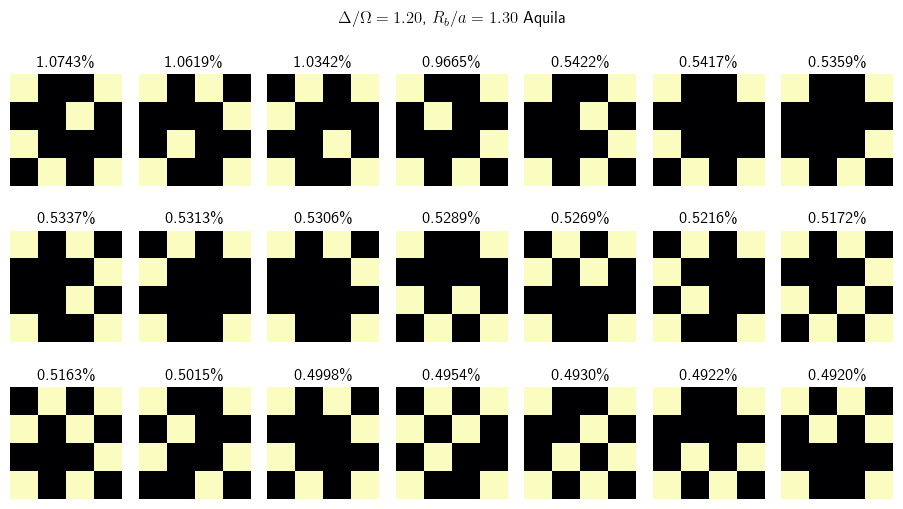

1.0093100000000002 +- 0.010046442156305882


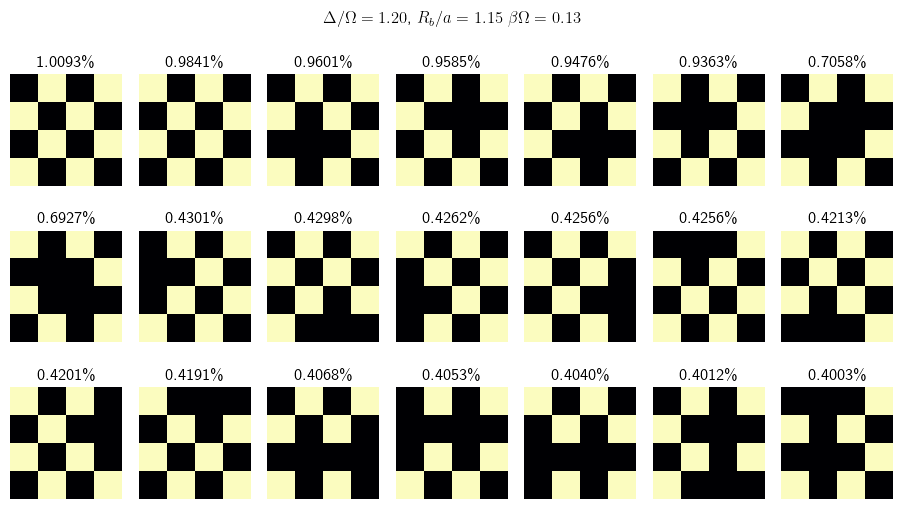

In [120]:
import h5py
import os
import matplotlib
import numpy as np
matplotlib.rcParams['text.usetex'] = True

with h5py.File(os.path.join(path, 'split_aquila.h5'), 'r') as file:
    av_occupation = np.mean(1 - file['postSequence/all'][:], axis=1)
    print("Average occupation:", np.mean(av_occupation),'+/-', np.std(av_occupation))
    av_occupation = np.mean(av_occupation)
    shots, natoms = file['postSequence/all'].shape
    real_hist, real_index_commonality = compute_histograms(1 - file['postSequence/all'][:])
    plot_common_configurations(real_hist/shots, real_index_commonality, natoms, delta=1.2,rb=1.3, show=True, title="Aquila")
    

plot_common_configurations(hist_list[-1]/1e7, index_commonality[-1], natoms, 
                           delta=dataset.delta_per_omega[0], rb=dataset.rb_per_a[0], 
                           show=True, title=rf'$\beta\Omega={dataset.beta[0]:.2f}$')
    

0.51880259401297


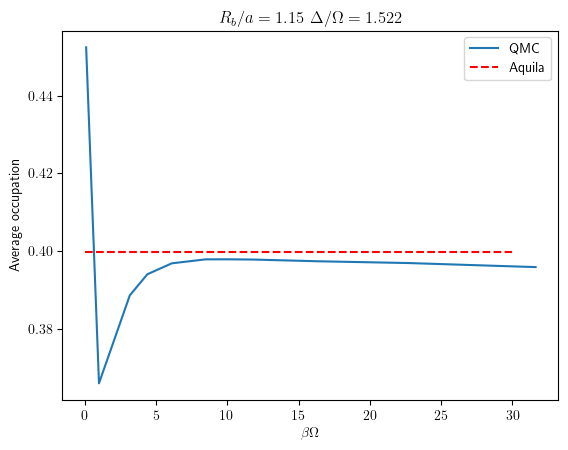

In [17]:
from scipy.interpolate import make_interp_spline
import numpy as np
si = np.argsort(dataset.beta)
# average_occupation = np.array([np.mean(data) for data in dataset.datasets])
plt.plot((np.array(dataset.beta)*np.array(dataset.omega))[si], average_occupation[si], label='QMC')
plt.xlabel(r"$\beta\Omega$")
plt.ylabel("Average occupation")
plt.title(r"$R_b/a=1.15$ $\Delta/\Omega=1.522$")

f = make_interp_spline((np.array(dataset.beta)*np.array(dataset.omega))[si], average_occupation[si])
x2 = np.linspace(0, 10, 200000)
y2 = f(x2)
i = np.argmin(np.abs(y2 - 0.3997578125))
plt.hlines(y=f(x2[i]), xmin=0, xmax=30, linestyle='--', color='r', label="Aquila")
print(x2[i])
plt.legend()

<ErrorbarContainer object of 3 artists>

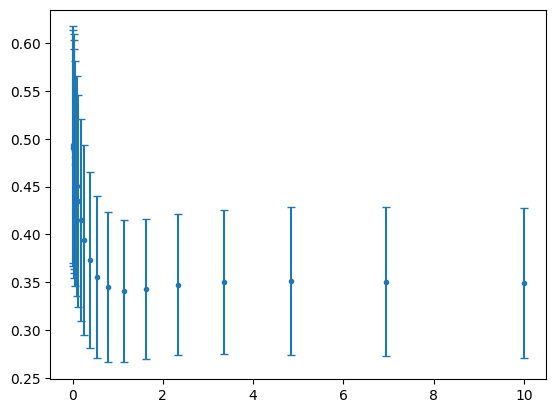

In [10]:
# print(np.array(dataset.beta)*np.array(dataset.omega))
plt.errorbar(x=np.array(dataset.beta)*np.array(dataset.omega), y=np.array(d)[:,0],yerr=np.array(d)[:,1],fmt='.', capsize=3)

Text(0, 0.5, 'Average occupation')

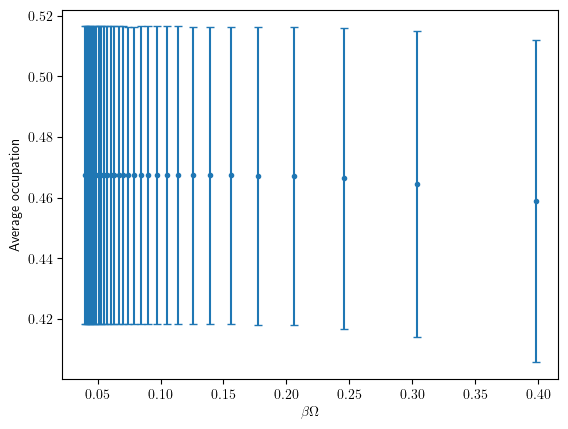

In [19]:
# print(np.array(dataset.beta)*np.array(dataset.omega))
import matplotlib
matplotlib.rcParams['text.usetex'] = True
plt.errorbar(x=1/(np.array(dataset.beta)*np.array(dataset.omega)), y=np.array(d)[:,0],yerr=np.array(d)[:,1],fmt='.', capsize=3)
plt.xlabel(r'$\beta\Omega$')
plt.ylabel("Average occupation")

In [17]:
print(np.array(dataset.delta_per_omega).shape,np.array(average_magnetization).shape)

(47,) (29,)


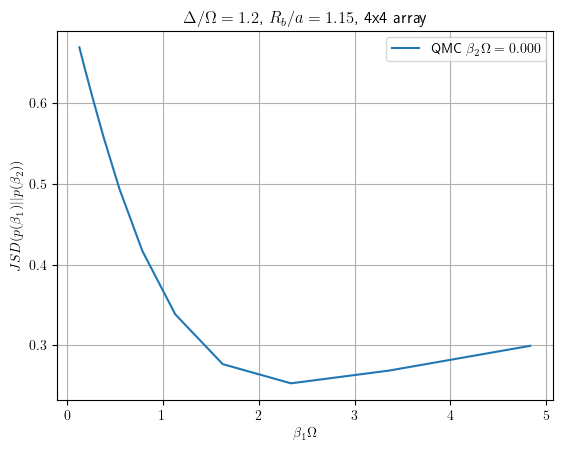

In [125]:
index = np.argsort(beta_list)
plt.rcParams['text.usetex'] = True
plot_JSD2([real_hist], np.array([hist/np.sum(hist) for hist in hist_list])[index] ,[0], np.array(beta_list)[index], show=True, save_filename=None)

[0.1274274985703134, 0.18329807108324356, 0.26366508987303566, 0.3792690190732249, 0.545559478116852, 0.7847599703514611, 1.1288378916846893, 1.6237767391887215, 2.3357214690901227, 3.359818286283781, 4.832930238571754]


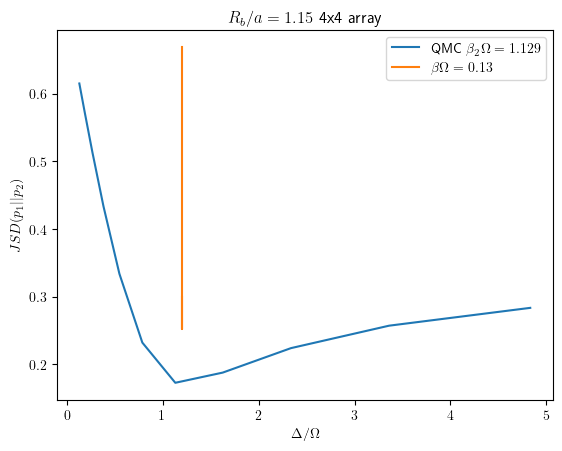

In [121]:
x = np.arange(2**16)
index = np.argsort(beta_list)
i = 6
print(beta_list)
nsamples = int(1e5)
sample = np.random.choice(x[:-1], size=(nsamples,), p=hist_list[i]/np.sum(hist_list[i]))
val, _ = np.histogram(sample, bins=x)
plot_JSD2([val/np.sum(val)],np.array([hist/np.sum(hist) for hist in hist_list])[index],
          [beta_list[i]], np.array(beta_list)[index], 
          show=False)
plot_JSD(real_hist/shots, 
            [h/np.sum(h) for h in np.array(hist_list)],
            np.array(dataset.delta_per_omega), 
        title=rf"$R_b/a={np.array(dataset.rb_per_a)[0]:.2f}$ 4x4 array",
        xlabel=r"$\Delta/\Omega$",
        label=fr"$\beta\Omega={(np.array(dataset.beta)*np.array(dataset.omega))[0]:.2f}$",
        show=False)

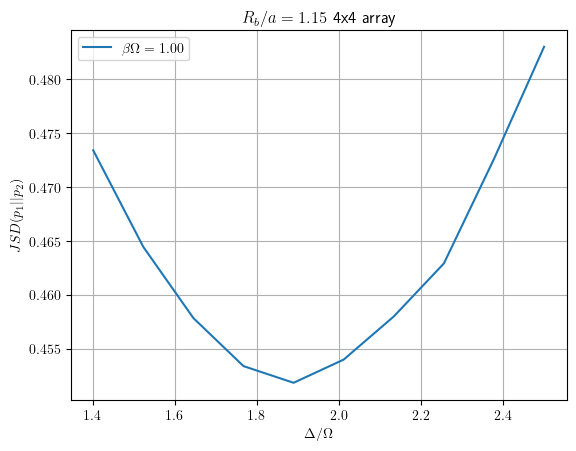

In [27]:
# plot_JSD2([val/np.sum(val)],np.array([hist/np.sum(hist) for hist in hist_list])[index],
#           [beta_list[17]], np.array(beta_list)[index], 
#           show=False)
# for beta in [1.0,10.0]:
#     _filter = np.isclose(np.array(dataset.beta),beta)
plot_JSD(real_hist/shots, 
            [h/np.sum(h) for h in np.array(hist_list)],
            np.array(dataset.delta_per_omega), 
        title=rf"$R_b/a={np.array(dataset.rb_per_a)[0]:.2f}$ 4x4 array",
        xlabel=r"$\Delta/\Omega$",
        label=fr"$\beta\Omega={(np.array(dataset.beta)*np.array(dataset.omega))[0]:.2f}$",
        show=False)
# plt.xscale('log')
# plt.show()

25.54456 +- 0.05054162640833791


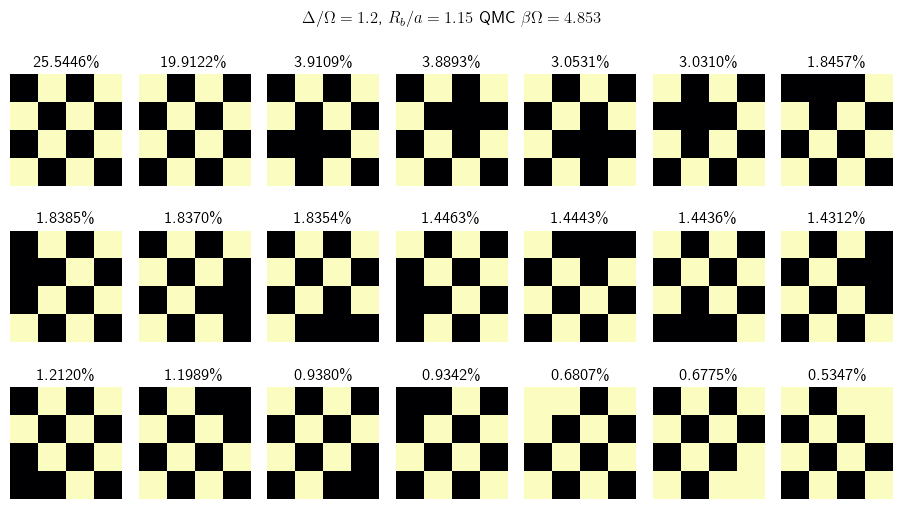

In [44]:
i = 3

plot_common_configurations(hist_list[i]/np.sum(hist_list[i]), index_commonality[i], natoms=16, show=True, title=rf"QMC $\beta\Omega={beta_list[i]*dataset.omega[i]:.3f}$")

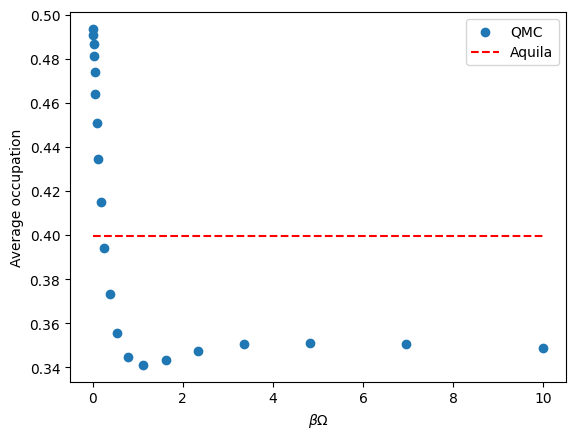

In [98]:
occupation = [np.mean(data) for data in dataset.datasets]
plt.scatter(beta_list, occupation, label='QMC')
plt.xlabel(r"$\beta\Omega$")
plt.ylabel("Average occupation")
plt.hlines(y=0.3997578125, xmin=0, xmax=10, linestyle='--', color='r', label='Aquila')
plt.legend()
plt.show()

In [89]:
from scipy.interpolate import make_interp_spline
import numpy as np

sort_i = np.argsort(beta_list)
f = make_interp_spline(np.array(beta_list)[sort_i], np.array(occupation)[sort_i])
x2 = np.linspace(0, 10, 200000)
y2 = f(x2)
i = np.argmin(np.abs(y2 - 0.3997578125))
print("Expected beta:",x2[i])

Expected beta: 0.23900119500597503


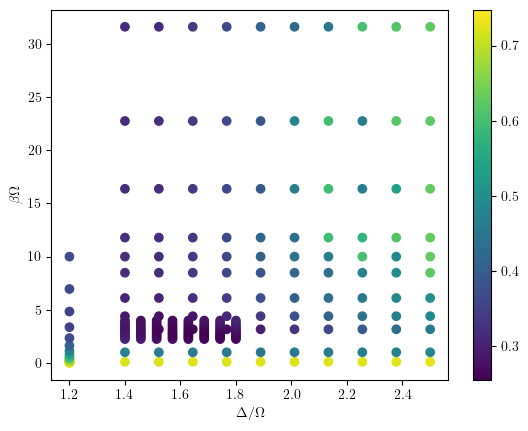

,real-QMC_JSD,real-QMC_JSD_std,QMC-QMC_JSD,QMC-QMC_JSD_std,omega,beta,delta_per_omega,beta*omega,rb_per_a,QMC_mean,QMC_mean_std
0,0.747357,0.000055,0.028672,0.000088,1,0.010000,1.200000,0.010000,1.15,0.493532,0.123787
1,0.745915,0.000053,0.028696,0.000096,1,0.014384,1.200000,0.014384,1.15,0.490706,0.123214
2,0.743934,0.000044,0.028673,0.000071,1,0.020691,1.200000,0.020691,1.15,0.486748,0.122475
3,0.741018,0.000043,0.028652,0.000085,1,0.029764,1.200000,0.029764,1.15,0.481405,0.121424
4,0.736892,0.000034,0.028647,0.000060,1,0.042813,1.200000,0.042813,1.15,0.473954,0.119882
...,...,...,...,...,...,...,...,...,...,...,...
68,0.314884,0.000123,0.020965,0.000078,1,31.622777,1.522222,31.622777,1.15,0.395867,0.073381
162,0.421146,0.000106,0.018124,0.000051,1,31.622777,2.011111,31.622777,1.15,0.446219,0.061455
206,0.625188,0.000061,0.012176,0.000046,1,31.622777,2.500000,31.622777,1.15,0.473223,0.053280
37,0.318651,0.000144,0.021386,0.000066,1,31.622777,1.400000,31.622777,1.15,0.377144,0.076226


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

df = pd.read_csv("/home/jkambulo/projects/def-rgmelko/jkambulo/code/qc-temp/full2_JSD.csv", index_col=0)
df = df.sort_values(by="beta*omega")

matplotlib.rcParams['text.usetex'] = True
plt.scatter(df['delta_per_omega'], df['beta*omega'], c=df['real-QMC_JSD'])
plt.xlabel(r"$\Delta/\Omega$")
plt.ylabel(r"$\beta\Omega$")
plt.colorbar()
plt.show()

df

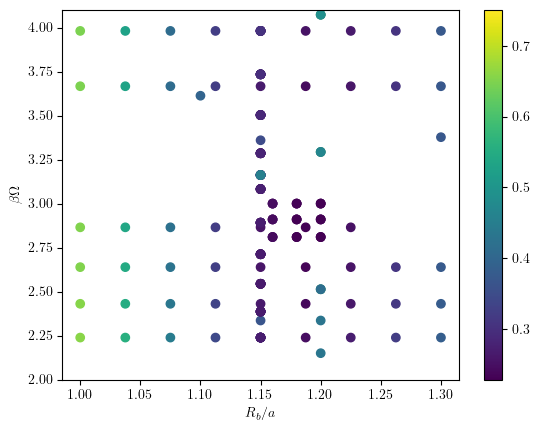

1.2


Text(0.5, 1.0, '$\\Delta/\\Omega=1.63$')

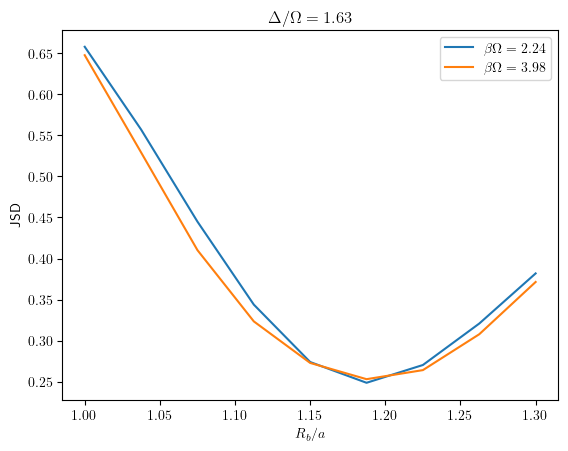

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

df = pd.read_csv("/home/jkambulo/projects/def-rgmelko/jkambulo/code/qc-temp/full_JSD_delta.csv", index_col=0)
df = df.sort_values(by=["beta*omega","rb_per_a"]).reset_index()

matplotlib.rcParams['text.usetex'] = True
plt.scatter(df['rb_per_a'], df['beta*omega'], c=df['real-QMC_JSD'])
plt.xlabel(r"$R_b/a$")
plt.ylabel(r"$\beta\Omega$")
plt.colorbar()
plt.ylim([2,4.1])
plt.show()

_filter =  (df['beta*omega'] < 2.3) & (df['delta_per_omega'] == 1.63)
plt.plot(df[_filter]['rb_per_a'],df[_filter]['real-QMC_JSD'], label=rf"$\beta\Omega={np.array(df[_filter]['beta*omega'])[0]:.2f}$")
_filter =  (df['beta*omega'] > 3.75)& (df['delta_per_omega'] == 1.63)
plt.plot(df[_filter]['rb_per_a'],df[_filter]['real-QMC_JSD'], label=rf"$\beta\Omega={np.array(df[_filter]['beta*omega'])[0]:.2f}$")

print(df.loc[np.argmin(df['real-QMC_JSD']), 'rb_per_a'])
plt.xlabel(r"$R_b/a$")
plt.ylabel(r"JSD")
plt.legend()
plt.title(r"$\Delta/\Omega=1.63$")

In [12]:
14.8/9

1.6444444444444446

Optimization terminated successfully.
         Current function value: 0.255158
         Iterations: 30
         Function evaluations: 58
[1.62984593 2.96100046]


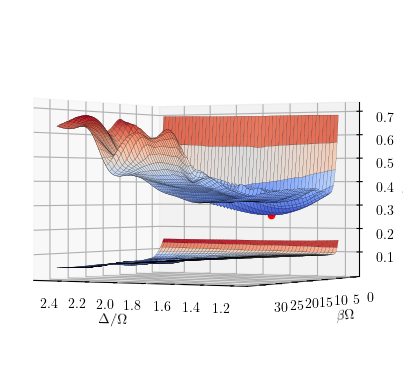

In [41]:
# %matplotlib widget
from scipy.interpolate import CloughTocher2DInterpolator
from scipy.optimize import fmin
import numpy as np

_filter = df['rb_per_a'] == 1.15
f = CloughTocher2DInterpolator(df[_filter][['delta_per_omega', 'beta*omega']], df[_filter]['real-QMC_JSD'])
f2 = CloughTocher2DInterpolator(df[_filter][['delta_per_omega', 'beta*omega']], df[_filter]['QMC-QMC_JSD'])
n = 150
x = np.linspace(1.2,2.5, n)
y = np.linspace(0,32, n)

xx, yy = np.meshgrid(x,y)
zz = f(np.moveaxis(np.stack([xx,yy]),0,-1).reshape(-1,2)).reshape(n,n)
zz2 = f2(np.moveaxis(np.stack([xx,yy]),0,-1).reshape(-1,2)).reshape(n,n)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
xy = fmin(f, np.array([1.5,3]))
ax.scatter3D([xy[0]], xy[1],f(xy),c='r')
print(xy)
surf = ax.plot_surface(xx, yy, zz, cmap=matplotlib.cm.coolwarm,
                       linewidth=0.1, antialiased=True, edgecolor='k')
surf = ax.plot_surface(xx, yy, zz2, cmap=matplotlib.cm.coolwarm,
                       linewidth=0.1, antialiased=True, edgecolor='k')


ax.set_xlabel(r"$\Delta/\Omega$")
ax.set_ylabel(r"$\beta\Omega$")
ax.set_zlabel("JSD")

ax.view_init(0,120,0)
plt.show()


[0.3990511] 0.3997578125


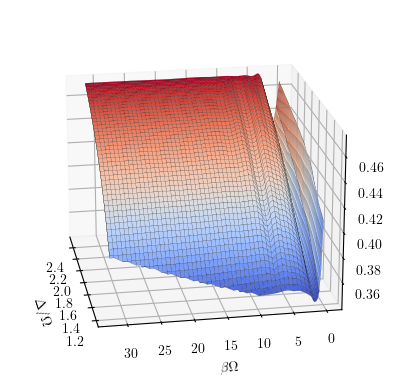

In [47]:
# %matplotlib widget
from scipy.interpolate import CloughTocher2DInterpolator
from scipy.optimize import fmin
import numpy as np

f = CloughTocher2DInterpolator(df[['delta_per_omega', 'beta*omega']], df['QMC_mean'])
n = 150
x = np.linspace(1.2,2.5, n)
y = np.linspace(0,32, n)

xx, yy = np.meshgrid(x,y)
zz = f(np.moveaxis(np.stack([xx,yy]),0,-1).reshape(-1,2)).reshape(n,n)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
print(f(xy), av_occupation)
surf = ax.plot_surface(xx, yy, zz, cmap=matplotlib.cm.coolwarm,
                       linewidth=0.1, antialiased=True, edgecolor='k')


ax.set_xlabel(r"$\Delta/\Omega$")
ax.set_ylabel(r"$\beta\Omega$")

ax.view_init(20,170,0)
plt.show()

In [42]:
import pandas as pd
import numpy as np
df = pd.read_csv("/home/jkambulo/projects/def-rgmelko/jkambulo/code/qc-temp/full_JSD_delta.csv", index_col=0)
df[df['real-QMC_JSD']==df['real-QMC_JSD'].min()]
# df[(df['rb_per_a']==1.2) & (df['beta*omega'] <4) & (df['beta*omega'] > 2)]

,real-QMC_JSD,real-QMC_JSD_std,QMC-QMC_JSD,QMC-QMC_JSD_std,omega,beta,delta_per_omega,beta*omega,rb_per_a
466,0.228463,0.000163,0.07577,0.00041,1.0,2.81,1.66,2.81,1.2


/tmp/ipykernel_13502/732873452.py:17: RuntimeWarning: divide by zero encountered in divide
  d_inv_6 = np.triu((1/((c[None]%rows - c[:,None]%rows)**2 +


-6.0 -7.0


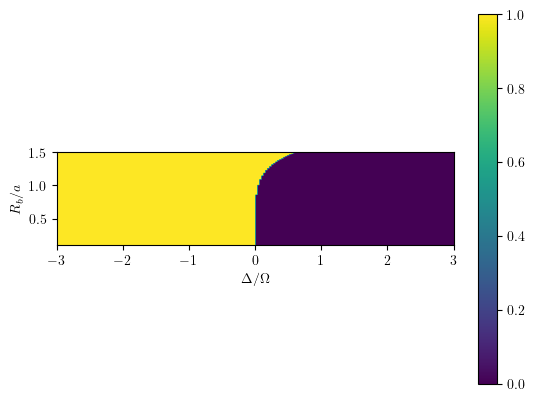

array([3.88241251e-59, 7.51819841e-55, 7.51819841e-55, ...,
       5.17243613e-02, 1.62184425e-01, 1.62184425e-01])

In [ ]:
import numpy as np

def compute_interaction(x):
    """Computes sum_ij Vij*ni*nj

    Args:
        x (torch.Tensor): tensor of shape (batchsize, natoms)

    Returns:
        torch.tensor: tensor of shape (batchsize,)
    """
    atoms = 16
    rows = 4
    x = x[:,None]
    c = np.arange(atoms)
    rows = round(np.sqrt(atoms))
    d_inv_6 = np.triu((1/((c[None]%rows - c[:,None]%rows)**2 +
                                (c[None]//rows - c[:,None]//rows)**2)**3),
                            k=1)
    i, j = np.triu_indices(atoms, k=1)
    filter = (x[i] == 1) & (x[j] == 1)
    return np.sum(d_inv_6[i[:, None] * filter, j[:, None] * filter])

def compute_classical_energy(x, delta_per_omega=1.6285714285714286, rb_per_a=1.15):
    """ x is 4x4 array """
    return -delta_per_omega*np.sum(x) + rb_per_a**6*compute_interaction(x.flatten())

energies = []
for i in range(2**16):
    arr = np.array(list(np.binary_repr(i).zfill(16))).astype(np.int8)
    energies.append(compute_classical_energy(arr))
    
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
state1 = np.array([[1, 0, 1, 0],
                    [0, 1, 0, 0],
                    [1, 0, 1, 0],
                    [0, 1, 0, 1]])
state2 = np.array([[1, 0, 1, 0],
                    [0, 0, 0, 1],
                    [1, 0, 0, 0],
                    [0, 1, 0, 1]])
state3 = np.zeros((4,4))


x = np.linspace(-3,3,200)
y = np.linspace(0,1.5,200)
xx, yy = np.meshgrid(x, y)
print(compute_classical_energy(state2,1,0),compute_classical_energy(state1,1,0))
# print(compute_classical_energy(state2, xx, yy))
# print(compute_classical_energy(state1, xx, yy))
# print(compute_classical_energy(state2, xx, yy))
data = compute_classical_energy(state2, xx, yy) > compute_classical_energy(state3, xx, yy)
plt.imshow(data, extent=[-3,3,0.1,1.5], origin='lower')
plt.colorbar()
plt.xlabel(r'$\Delta/\Omega$')
plt.ylabel(r'$R_b/a$')
plt.show()

beta=2.8914195365796784

np.sort(np.exp(-beta*np.array(energies))/np.sum(np.exp(-beta*np.array(energies))))
# np.array(list(np.binary_repr(np.argsort(energies)[6]).zfill(16))).astype(np.int8).reshape(4,4)